<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, BatchNormalization, Dropout

from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, MaxPooling3D

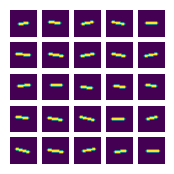

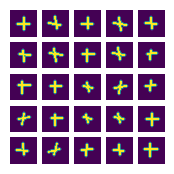

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7882

X_text: "39+41" = y_text: "80 "


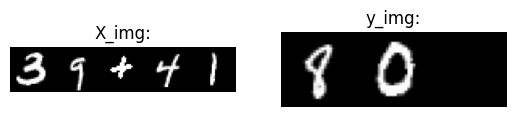

Query #7867

X_text: "39-33" = y_text: "6  "


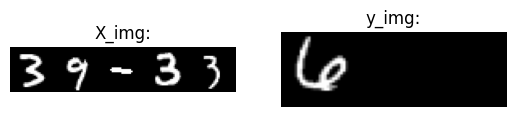

Query #8373

X_text: "41-86" = y_text: "-45"


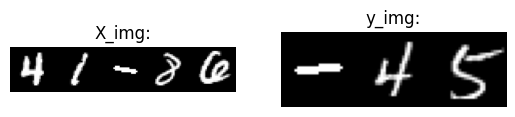

Query #8125

X_text: "40-62" = y_text: "-22"


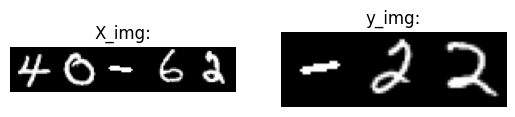

Query #4508

X_text: "22+54" = y_text: "76 "


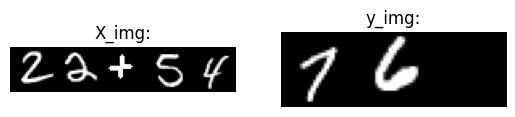

Query #6888

X_text: "34+44" = y_text: "78 "


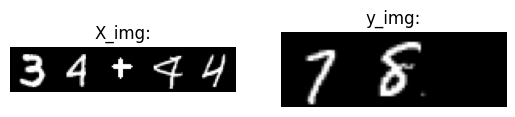

Query #8524

X_text: "42+62" = y_text: "104"


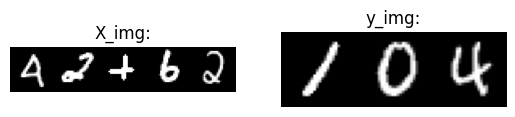

Query #4208

X_text: "21+4 " = y_text: "25 "


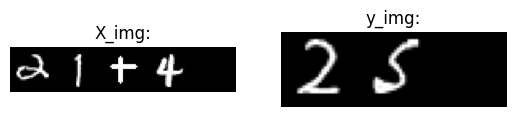

Query #4720

X_text: "23+60" = y_text: "83 "


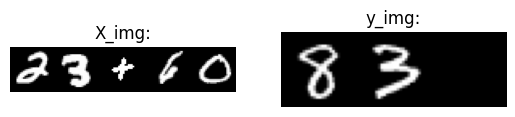

Query #8471

X_text: "42-35" = y_text: "7  "


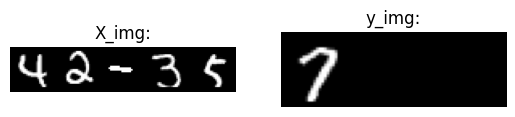

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [7]:
#splits for training and test sets 
X_text_train, X_text_test, X_img_train, X_img_test, y_text_train, y_text_test, y_img_train, y_img_test, X_text_onehot_train, X_text_onehot_test, y_text_onehot_train, y_text_onehot_test= train_test_split(
    X_text, X_img, y_text, y_img,X_text_onehot,y_text_onehot, test_size=0.5, random_state=42
)

2024-12-05 02:25:36.348712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2024-12-05 02:25:36.348728: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-05 02:25:36.348731: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-05 02:25:36.348749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-05 02:25:36.348757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Se

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-12-05 02:25:36.879083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3172 - loss: 2.0984 - val_accuracy: 0.4187 - val_loss: 1.6265
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4349 - loss: 1.5671 - val_accuracy: 0.4498 - val_loss: 1.4492
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5024 - loss: 1.3643 - val_accuracy: 0.5432 - val_loss: 1.2526
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5497 - loss: 1.2326 - val_accuracy: 0.5647 - val_loss: 1.1834
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 190ms/step - accuracy: 0.5798 - loss: 1.1467 - val_accuracy: 0.5935 - val_loss: 1.1086
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5998 - loss: 1.0871 - val_accuracy: 0.5786 - val_loss: 1.1295
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6085 - loss: 1.0465 - val_accuracy: 0.6311 - val_loss: 1.0068
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6231 - loss: 1.0211 - val_accuracy: 0.6

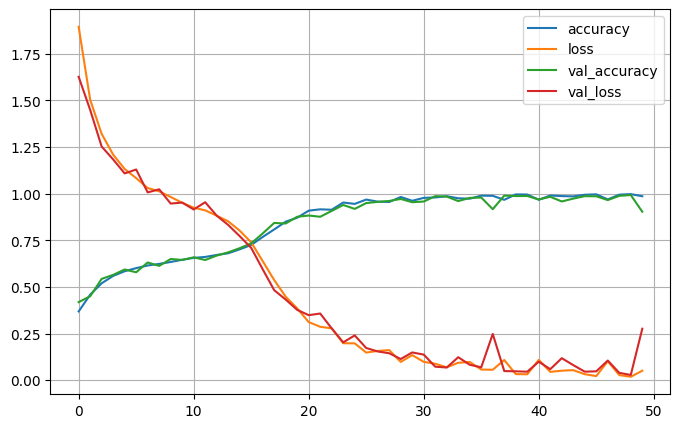

In [8]:
#Train Model
model = build_text2text_model()

batch_size = 32
epochs = 50
history = model.fit(X_text_onehot_train, y_text_onehot_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_text_onehot_test, y_text_onehot_test))
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()


In [9]:
#Verify the predictions
predictions = model.predict(X_text_onehot_test)

correct_predictions = []
X_text_predictions = []
X_text_predictions_int = []
y_text_test_int = []
for i in range(len(y_text_test)):
    X_value=decode_labels(predictions[i])
    X_text_predictions.append(X_value)
    correct_predictions.append(np.array_equal(X_text_predictions[i], y_text_test[i]))
    try:
        X_text_predictions_int.append(int(X_value))
    except ValueError:
        X_text_predictions_int.append(0)  #if fail, set X_text_predictions_int=0
    try:
        y_text_test_int.append(int(y_text_test[i]))
    except ValueError:
        y_text_test_int.append(0)  #if fail, set X_text_predictions_int=0

X_text_predictions_int = np.array(X_text_predictions_int)
y_text_test_int = np.array(y_text_test_int)
accuracy = sum(correct_predictions) / len(y_text_test)
mean_absolute_error = np.mean(np.abs(X_text_predictions_int - y_text_test_int))

print(f"Accuracy: {accuracy}")
print(f"Mean Absolute Error: {mean_absolute_error}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7403
Mean Absolute Error: 1.7725


Error #0

X_text: "59-81" = y_text: "-22",y_predict:"-21"
Error #1

X_text: "98-85" = y_text: "13 ",y_predict:"24 "
Error #2

X_text: "17-62" = y_text: "-45",y_predict:"-44"
Error #3

X_text: "39-39" = y_text: "0  ",y_predict:"1  "
Error #4

X_text: "81+48" = y_text: "129",y_predict:"130"
Error #5

X_text: "96-96" = y_text: "0  ",y_predict:"1  "
Error #6

X_text: "83+98" = y_text: "181",y_predict:"182"
Error #7

X_text: "49-61" = y_text: "-12",y_predict:"-11"
Error #8

X_text: "37-29" = y_text: "8  ",y_predict:"9  "
Error #9

X_text: "69-17" = y_text: "52 ",y_predict:"53 "
Error #10

X_text: "82-43" = y_text: "39 ",y_predict:"49 "
Error #11

X_text: "78+49" = y_text: "127",y_predict:"117"
Error #12

X_text: "85-29" = y_text: "56 ",y_predict:"57 "
Error #13

X_text: "92+47" = y_text: "139",y_predict:"130"
Error #14

X_text: "7-9  " = y_text: "-2 ",y_predict:"-1 "
Error #15

X_text: "88-8 " = y_text: "80 ",y_predict:"71 "
Error #16

X_text: "38-56" = y_text: "-18",y_predict:"-17"
Error #

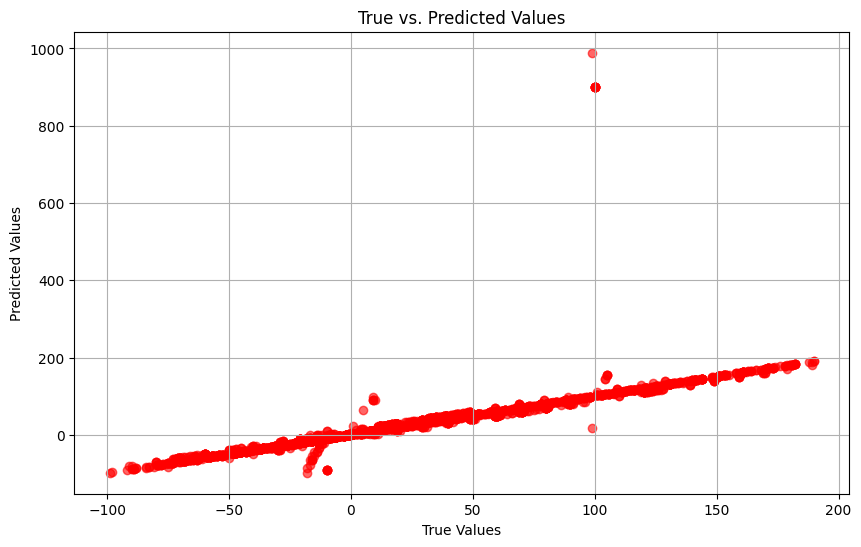

In [10]:
#Plot the resluts
incorrect_indices = [i for i, correct in enumerate(correct_predictions) if not correct]
for i in range(len(incorrect_indices)):
    ind=incorrect_indices[i]
    print('='*50, f'\nError #{i}\n\nX_text: "{X_text_test[ind]}" = y_text: "{y_text_test[ind]}",y_predict:"{X_text_predictions[ind]}"')

plt.figure(figsize=(10, 6))
plt.scatter([y_text_test_int[i] for i in incorrect_indices],[X_text_predictions_int[i] for i in incorrect_indices], color='red', alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [11]:
def build_image2text_model():

    # We start by initializing a sequential model
    image2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    image2text.add(ConvLSTM2D(#use ConvLSTM2D
        filters=16,                    
        kernel_size=(3, 3),            
        return_sequences=True,
        input_shape=(None, X_img_train.shape[2],X_img_train.shape[3],1), 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    image2text.add(BatchNormalization())
    image2text.add(MaxPooling3D(pool_size=(1, 2, 2)))
    image2text.add(Dropout(0.2))
    image2text.add(ConvLSTM2D(#use ConvLSTM2D
        filters=32,                    
        kernel_size=(3, 3),            
        return_sequences=False,
        input_shape=(None, X_img_train.shape[2],X_img_train.shape[3],1), 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    image2text.add(BatchNormalization())
    image2text.add(Dropout(0.2))

    image2text.add(Flatten())#2D to 1D, the input is in 2D, while the output is in 1D

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    image2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    image2text.add(LSTM(128, return_sequences=True))
    image2text.add(Dropout(0.2))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    image2text.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    image2text.summary()

    return image2text

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 26, 26,   │         9,856 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 26, 26,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, None, 13, 13,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 13, 13,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 11, 11, 32)     │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 3872)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 128)         │     2,048,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         1,677 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,115,661 (8.07 MB)

 Trainable params: 2,115,565 (8.07 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 164ms/step - accuracy: 0.3084 - loss: 2.2351 - val_accuracy: 0.0983 - val_loss: 2.5114 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.3886 - loss: 1.8606 - val_accuracy: 0.2161 - val_loss: 2.5231 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.4063 - loss: 1.7550 - val_accuracy: 0.3929 - val_loss: 1.8492 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.4329 - loss: 1.6813 - val_accuracy: 0.4006 - val_loss: 1.7718 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.4562 - loss: 1.6146 - val_accuracy: 0.4073 - val_loss: 1.7621 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.4813 - loss: 1.5452 - val_accuracy: 0.4145 - val_loss: 1.7572 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.5

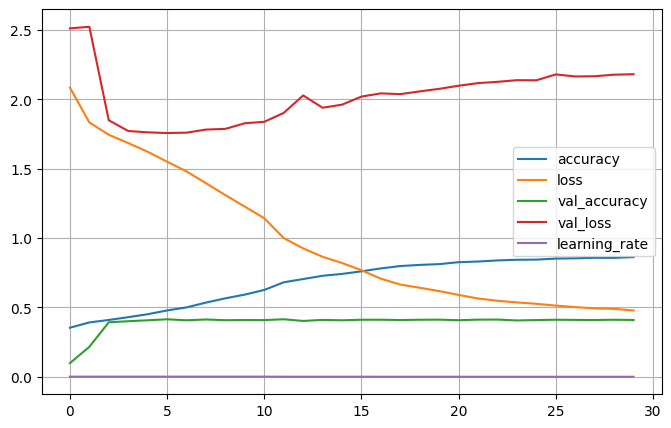

In [12]:
model2 = build_image2text_model()

batch_size2 = 32
epochs2 = 30
Learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history2 = model2.fit(X_img_train, y_text_onehot_train,
          batch_size=batch_size2,
          epochs=epochs2,
          verbose=1,
          validation_data=(X_img_test, y_text_onehot_test),
          callbacks=[Learning_rate])
df = pd.DataFrame(history2.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [13]:
#Verify the predictions
predictions2 = model2.predict(X_img_test)

correct_predictions2 = []
X_text_predictions2 = []
X_text_predictions_int2 = []
y_text_test_int2 = []
for i in range(len(y_text_test)):
    X_value2=decode_labels(predictions2[i])
    X_text_predictions2.append(X_value2)
    correct_predictions2.append(np.array_equal(X_text_predictions2[i], y_text_test[i]))
    try:
        X_text_predictions_int2.append(int(X_value2))
    except ValueError:
        X_text_predictions_int2.append(0)  #if fail, set X_text_predictions_int=0


X_text_predictions_int2 = np.array(X_text_predictions_int2)
accuracy2 = sum(correct_predictions2) / len(y_text_test)
mean_absolute_error2 = np.mean(np.abs(X_text_predictions_int2 - y_text_test_int))

print(f"Accuracy: {accuracy2}")
print(f"Mean Absolute Error: {mean_absolute_error2}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Accuracy: 0.0179
Mean Absolute Error: 28.3626


Error #0

X_text: "53+25" = y_text: "78 ",y_predict:"11 "
Error #1

X_text: "10-20" = y_text: "-10",y_predict:"-5 "
Error #2

X_text: "43+34" = y_text: "77 ",y_predict:"60 "
Error #3

X_text: "5+57 " = y_text: "62 ",y_predict:"34 "
Error #4

X_text: "69+51" = y_text: "120",y_predict:"110"
Error #5

X_text: "59-81" = y_text: "-22",y_predict:"-1 "
Error #6

X_text: "55+36" = y_text: "91 ",y_predict:"12 "
Error #7

X_text: "15+1 " = y_text: "16 ",y_predict:"33 "
Error #8

X_text: "98-85" = y_text: "13 ",y_predict:"38 "
Error #9

X_text: "40-57" = y_text: "-17",y_predict:"-55"
Error #10

X_text: "17-62" = y_text: "-45",y_predict:"-43"
Error #11

X_text: "39-39" = y_text: "0  ",y_predict:"-17"
Error #12

X_text: "82-20" = y_text: "62 ",y_predict:"68 "
Error #13

X_text: "81+48" = y_text: "129",y_predict:"147"
Error #14

X_text: "62+83" = y_text: "145",y_predict:"166"
Error #15

X_text: "26+26" = y_text: "52 ",y_predict:"86 "
Error #16

X_text: "96-96" = y_text: "0  ",y_predict:"-6 "
Error #

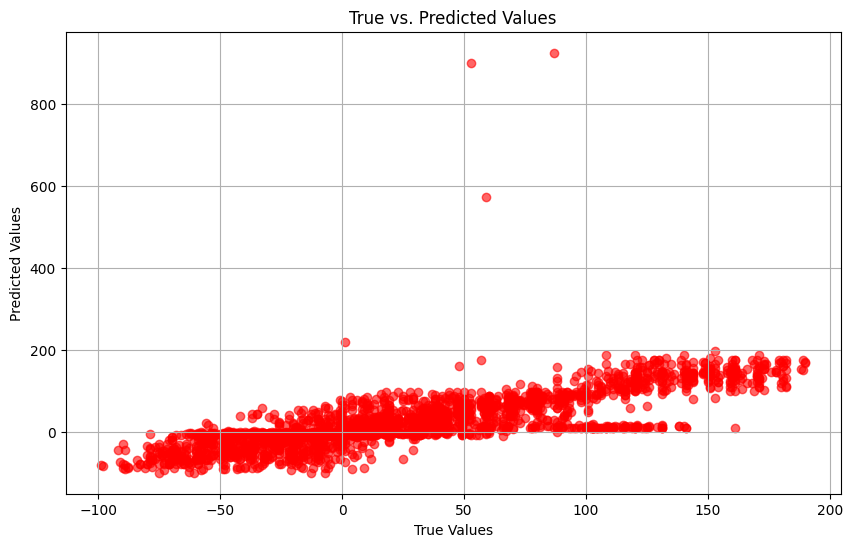

In [14]:
#Plot the resluts
incorrect_indices2 = [i for i, correct in enumerate(correct_predictions2) if not correct]
for i in range(len(incorrect_indices2)):
    ind=incorrect_indices2[i]
    print('='*50, f'\nError #{i}\n\nX_text: "{X_text_test[ind]}" = y_text: "{y_text_test[ind]}",y_predict:"{X_text_predictions2[ind]}"')

plt.figure(figsize=(10, 6))
plt.scatter([y_text_test_int[i] for i in incorrect_indices],[X_text_predictions_int2[i] for i in incorrect_indices], color='red', alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [15]:
def build_text2image_model():

    # We start by initializing a sequential model
    text2image = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2image.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=False))
    text2image.add(Dropout(0.2))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2image.add(Dense(128 * 7 * 7, activation='relu'))
    text2image.add(Reshape((128, 7, 7)))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2image.add(Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Dropout(0.2))
    text2image.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())

    # Output layer: Conv2DTranspose to generate a 28x28 grayscale image
    text2image.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', data_format='channels_first'))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2image.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])
    text2image.summary()

    return text2image

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6272)           │     3,217,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 7, 7)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 14, 14)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 14, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256, 14, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 28, 28)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 28, 28)    │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 28, 28)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 28, 28)     │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 28, 28)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 28, 28)     │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 3, 28, 28)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,978,507 (18.99 MB)

 Trainable params: 4,978,311 (18.99 MB)

 Non-trainable params: 196 (784.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - loss: 0.1508 - mean_absolute_error: 0.2658 - val_loss: 0.0833 - val_mean_absolute_error: 0.1863 - learning_rate: 1.0000e-04
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - loss: 0.0550 - mean_absolute_error: 0.1368 - val_loss: 0.0657 - val_mean_absolute_error: 0.1602 - learning_rate: 1.0000e-04
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.0537 - mean_absolute_error: 0.1309 - val_loss: 0.0524 - val_mean_absolute_error: 0.1195 - learning_rate: 1.0000e-04
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.0524 - mean_absolute_error: 0.1268 - val_loss: 0.0515 - val_mean_absolute_error: 0.1219 - learning_rate: 1.0000e-04
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 563ms/step - loss: 0.0515 - mean_absolute_error: 0.1249 - val_loss: 0.0507 - val_mean_absolute_error: 0.1166 - learning_rate: 1.0000e-04
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - loss: 0.0509 - mean_absolute_error: 0.1229

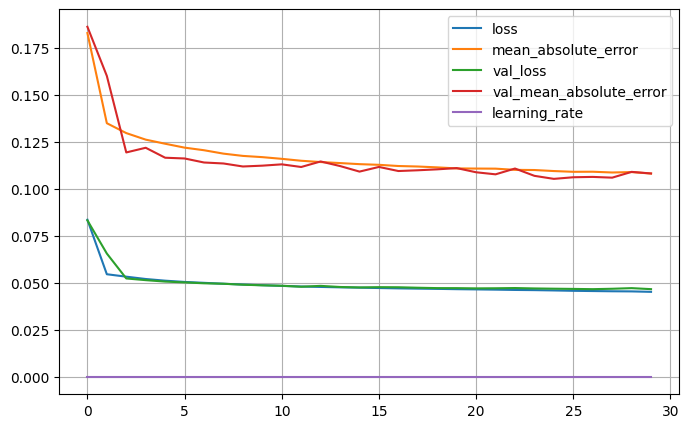

In [16]:
#Train Model
model3 = build_text2image_model()

batch_size3 = 32
epochs3 = 30
Learning_rate2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history3 = model3.fit(X_text_onehot_train, y_img_train,
          batch_size=batch_size3,
          epochs=epochs3,
          verbose=1,
          validation_data=(X_text_onehot_test, y_img_test),
          callbacks=[Learning_rate2])
df = pd.DataFrame(history3.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


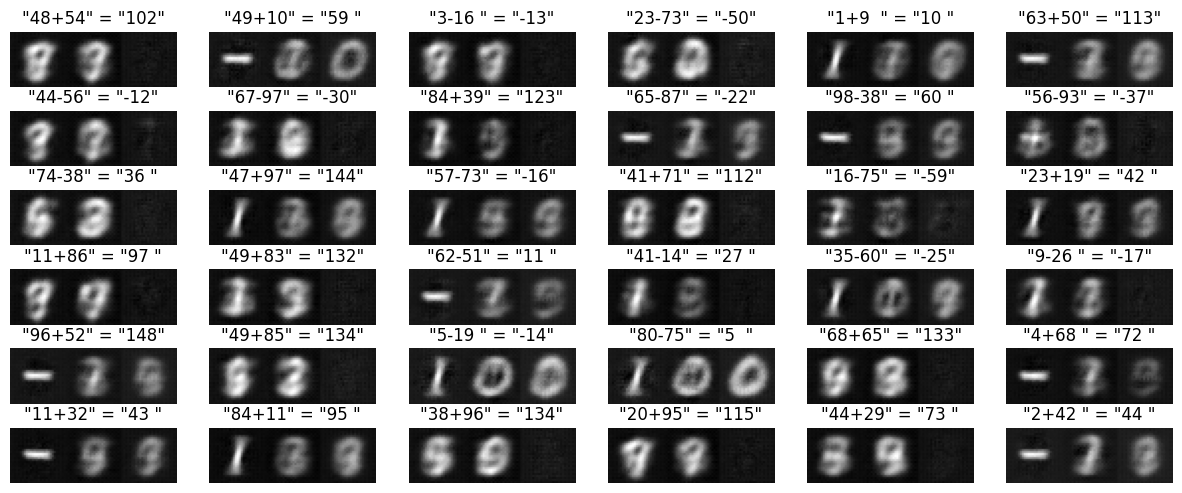

In [17]:
predictions3 = model3.predict(X_text_onehot_test)

n = 6
num_samples = n*n
indices3 = np.random.choice(len(predictions3), num_samples, replace=False)
X_text_test_samples3 = [X_text_test[i] for i in indices3]
y_text_test_samples3 = [y_text_test[i] for i in indices3]
plt.figure(figsize=(2*n+3, n))
for i in range(num_samples):
    plt.subplot(n, n, i + 1)
    plt.imshow(np.hstack(predictions3[i]), cmap='gray')
    plt.title(f'"{X_text_test_samples3[i]}" = "{y_text_test_samples3[i]}"')
    plt.axis('off')
plt.show()

---
---

## IV. Adding additional LSTM layers for Image to text RNN Model

In [18]:
def build_image2text_model2():

    # We start by initializing a sequential model
    image2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    image2text.add(ConvLSTM2D(#use ConvLSTM2D
        filters=16,                    
        kernel_size=(3, 3),            
        return_sequences=True,
        input_shape=(None, X_img_train.shape[2],X_img_train.shape[3],1), 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    image2text.add(BatchNormalization())
    image2text.add(MaxPooling3D(pool_size=(1, 2, 2)))
    image2text.add(Dropout(0.2))
    image2text.add(ConvLSTM2D(#use ConvLSTM2D
        filters=32,                    
        kernel_size=(3, 3),            
        return_sequences=False,
        input_shape=(None, X_img_train.shape[2],X_img_train.shape[3],1), 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    image2text.add(BatchNormalization())
    image2text.add(Dropout(0.2))

    image2text.add(Flatten())#2D to 1D, the input is in 2D, while the output is in 1D

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    image2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    image2text.add(LSTM(256, return_sequences=True))
    image2text.add(Dropout(0.2))
    image2text.add(LSTM(128, return_sequences=True))
    image2text.add(Dropout(0.2))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    image2text.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    image2text.summary()

    return image2text

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 26, 26,   │         9,856 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 26, 26,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, None, 13, 13,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 13, 13,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 11, 11, 32)     │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 3872)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 256)         │     4,228,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         1,677 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,492,365 (17.14 MB)

 Trainable params: 4,492,269 (17.14 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.3170 - loss: 2.1489 - val_accuracy: 0.1410 - val_loss: 2.5987 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 174ms/step - accuracy: 0.3951 - loss: 1.8161 - val_accuracy: 0.3735 - val_loss: 1.9560 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.4045 - loss: 1.7394 - val_accuracy: 0.4121 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.4276 - loss: 1.6630 - val_accuracy: 0.4251 - val_loss: 1.6518 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 176ms/step - accuracy: 0.4381 - loss: 1.6043 - val_accuracy: 0.4114 - val_loss: 1.7218 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.4557 - loss: 1.5546 - val_accuracy: 0.4394 - val_loss: 1.6139 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.4

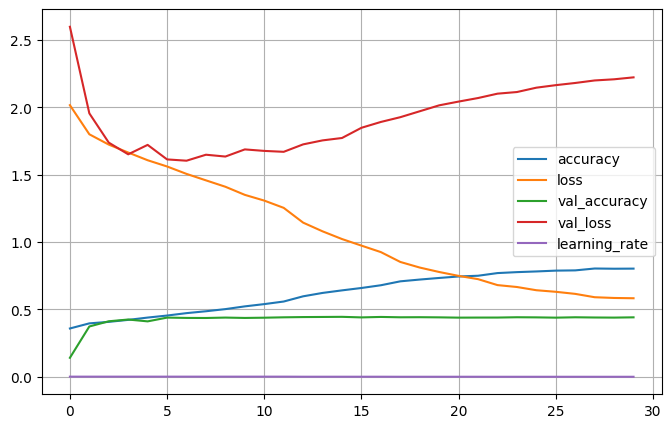

In [19]:
model4 = build_image2text_model2()

batch_size4 = 32
epochs4 = 30
Learning_rate4 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history4 = model4.fit(X_img_train, y_text_onehot_train,
          batch_size=batch_size4,
          epochs=epochs4,
          verbose=1,
          validation_data=(X_img_test, y_text_onehot_test),
          callbacks=[Learning_rate4])
df = pd.DataFrame(history4.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [20]:
#Verify the predictions
predictions4 = model4.predict(X_img_test)

correct_predictions4 = []
X_text_predictions4 = []
X_text_predictions_int4 = []
y_text_test_int4 = []
for i in range(len(y_text_test)):
    X_value4=decode_labels(predictions4[i])
    X_text_predictions4.append(X_value4)
    correct_predictions4.append(np.array_equal(X_text_predictions4[i], y_text_test[i]))
    try:
        X_text_predictions_int4.append(int(X_value4))
    except ValueError:
        X_text_predictions_int4.append(0)  #if fail, set X_text_predictions_int=0


X_text_predictions_int4 = np.array(X_text_predictions_int4)
accuracy4 = sum(correct_predictions4) / len(y_text_test)
mean_absolute_error4 = np.mean(np.abs(X_text_predictions_int4 - y_text_test_int))

print(f"Accuracy: {accuracy4}")
print(f"Mean Absolute Error: {mean_absolute_error4}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step
Accuracy: 0.0272
Mean Absolute Error: 17.5532


Error #0

X_text: "53+25" = y_text: "78 ",y_predict:"64 "
Error #1

X_text: "10-20" = y_text: "-10",y_predict:"-40"
Error #2

X_text: "43+34" = y_text: "77 ",y_predict:"85 "
Error #3

X_text: "5+57 " = y_text: "62 ",y_predict:"58 "
Error #4

X_text: "69+51" = y_text: "120",y_predict:"126"
Error #5

X_text: "59-81" = y_text: "-22",y_predict:"-5 "
Error #6

X_text: "55+36" = y_text: "91 ",y_predict:"12 "
Error #7

X_text: "15+1 " = y_text: "16 ",y_predict:"25 "
Error #8

X_text: "98-85" = y_text: "13 ",y_predict:"58 "
Error #9

X_text: "40-57" = y_text: "-17",y_predict:"-47"
Error #10

X_text: "17-62" = y_text: "-45",y_predict:"-47"
Error #11

X_text: "39-39" = y_text: "0  ",y_predict:"2  "
Error #12

X_text: "82-20" = y_text: "62 ",y_predict:"68 "
Error #13

X_text: "81+48" = y_text: "129",y_predict:"142"
Error #14

X_text: "62+83" = y_text: "145",y_predict:"157"
Error #15

X_text: "26+26" = y_text: "52 ",y_predict:"96 "
Error #16

X_text: "96-96" = y_text: "0  ",y_predict:"-3 "
Error #

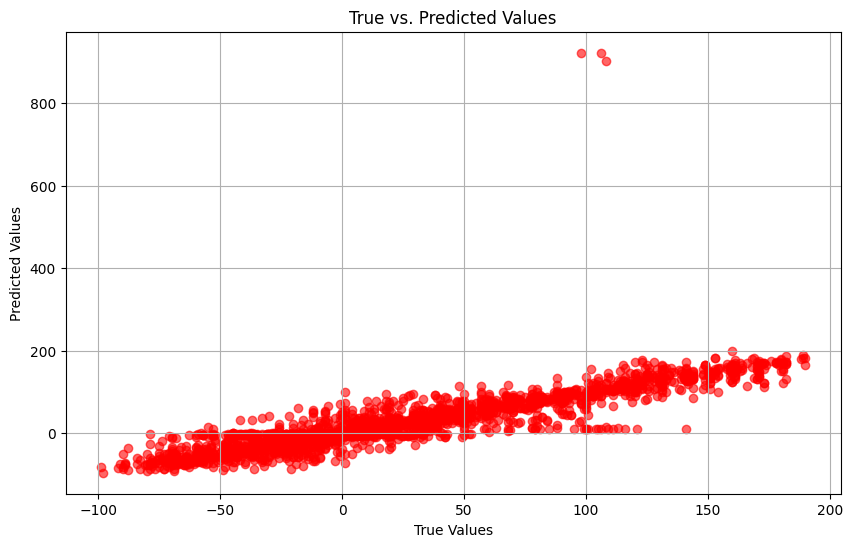

In [21]:
#Plot the resluts
incorrect_indices4 = [i for i, correct in enumerate(correct_predictions4) if not correct]
for i in range(len(incorrect_indices4)):
    ind=incorrect_indices4[i]
    print('='*50, f'\nError #{i}\n\nX_text: "{X_text_test[ind]}" = y_text: "{y_text_test[ind]}",y_predict:"{X_text_predictions4[ind]}"')

plt.figure(figsize=(10, 6))
plt.scatter([y_text_test_int[i] for i in incorrect_indices],[X_text_predictions_int4[i] for i in incorrect_indices], color='red', alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()

---
---

## V. Adding additional LSTM layers for Text to image RNN Model

In [22]:
def build_text2image_model2():

    # We start by initializing a sequential model
    text2image = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2image.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2image.add(Dropout(0.2))
    text2image.add(LSTM(256, return_sequences=True))
    text2image.add(LSTM(128, return_sequences=True))
    text2image.add(LSTM(64, return_sequences=False))


    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2image.add(Dense(128 * 7 * 7, activation='relu'))
    text2image.add(Reshape((128, 7, 7)))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2image.add(Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Dropout(0.2))
    text2image.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())
    text2image.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', data_format='channels_first'))
    text2image.add(BatchNormalization())

    # Output layer: Conv2DTranspose to generate a 28x28 grayscale image
    text2image.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh', data_format='channels_first'))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2image.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])
    text2image.summary()

    return text2image

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, None, 512)      │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, None, 256)      │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, None, 128)      │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6272)           │       407,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 128, 7, 7)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 14, 14)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256, 14, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256, 14, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 128, 28, 28)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 28, 28)    │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 28, 28)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 28, 28)     │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 28, 28)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 28, 28)     │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 3, 28, 28)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,202,635 (12.22 MB)

 Trainable params: 3,202,439 (12.22 MB)

 Non-trainable params: 196 (784.00 B)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - loss: 0.1356 - mean_absolute_error: 0.2517 - val_loss: 0.2031 - val_mean_absolute_error: 0.3223 - learning_rate: 1.0000e-04
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - loss: 0.0560 - mean_absolute_error: 0.1400 - val_loss: 0.0894 - val_mean_absolute_error: 0.2073 - learning_rate: 1.0000e-04
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 0.0541 - mean_absolute_error: 0.1324 - val_loss: 0.0532 - val_mean_absolute_error: 0.1218 - learning_rate: 1.0000e-04
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 0.0535 - mean_absolute_error: 0.1299 - val_loss: 0.0525 - val_mean_absolute_error: 0.1230 - learning_rate: 1.0000e-04
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 0.0527 - mean_absolute_error: 0.1268 - val_loss: 0.0515 - val_mean_absolute_error: 0.1175 - learning_rate: 1.0000e-04
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 0.0512 - mean_absolute_error: 0.1232 

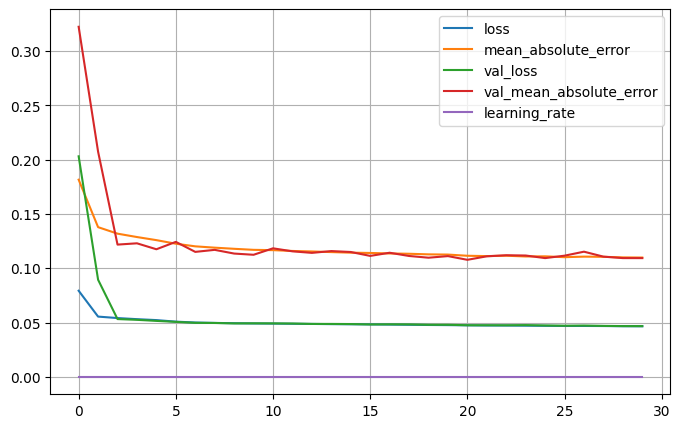

In [23]:
#Train Model
model5 = build_text2image_model2()

batch_size5 = 32
epochs5 = 30
Learning_rate5 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history5 = model5.fit(X_text_onehot_train, y_img_train,
          batch_size=batch_size5,
          epochs=epochs5,
          verbose=1,
          validation_data=(X_text_onehot_test, y_img_test),
          callbacks=[Learning_rate5])
df = pd.DataFrame(history5.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


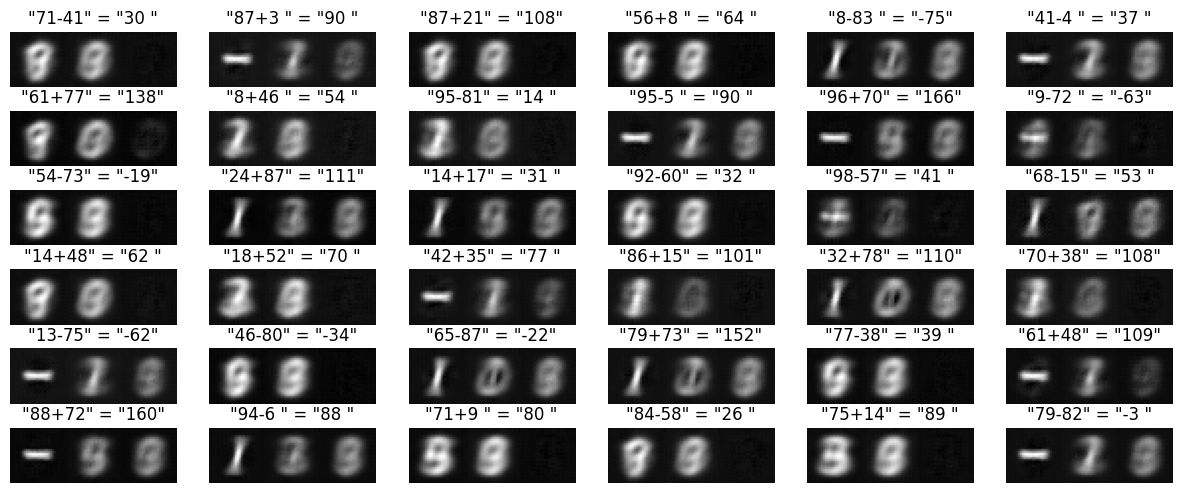

In [24]:
predictions5 = model5.predict(X_text_onehot_test)

n = 6
num_samples = n*n
indices5 = np.random.choice(len(predictions5), num_samples, replace=False)
X_text_test_samples5 = [X_text_test[i] for i in indices5]
y_text_test_samples5 = [y_text_test[i] for i in indices5]
plt.figure(figsize=(2*n+3, n))
for i in range(num_samples):
    plt.subplot(n, n, i + 1)
    plt.imshow(np.hstack(predictions5[i]), cmap='gray')
    plt.title(f'"{X_text_test_samples5[i]}" = "{y_text_test_samples5[i]}"')
    plt.axis('off')
plt.show()